In [1]:
import numpy as np
from partition_decode.models import ReluNetClassifier, ReluNetRegressor
from partition_decode.dataset import generate_gaussian_parity, recursive_gaussian_parity, generate_spirals, load_mnist
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from partition_decode.df_utils import (
    get_tree_evals,
    get_forest_evals,
    get_forest_irm,
    get_tree_irm,
)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
import os
from scipy.stats import spearmanr, entropy

sns.set_style('white')
sns.set_context('notebook')

## Load results

In [20]:
algo = "relu_regressor"
dataset = "mnist"

path = f'./varying_model_results/{dataset}/irms/'
irms = []
for f in sorted(os.listdir(path)):
    if algo in f:
        irms.append(np.load(path + f))

In [21]:
# Read
df = pd.read_csv(f'./varying_model_results/{dataset}/{dataset}_{algo}_results.csv', index_col=0)

# Define headers
metric = "01_error"
train_error = f'train_{metric}'
test_error = f'test_{metric}'

# Set to floats
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass

# Create new metrics/columns
df['generalization_gap'] = df[test_error] - df[train_error]
df["IRM_cols_mean_L1"] = df["IRM_cols_mean_L1"] / df["n_train_samples"]
df["IRM_cols_mean_L2"] = df["IRM_cols_mean_L2"] / df["n_train_samples"]
df['IRM_L1'] = df["IRM_L1"] / df["n_train_samples"]

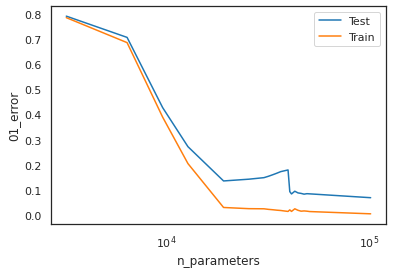

In [22]:
plot_df = df

fig, ax = plt.subplots(1, 1, sharex=True)

# ax.axvline(10*df['n_train_samples'].iloc[0], ls='--', c='black', label='Interpolation threshold')
x_var = "n_parameters" #  'n_total_leaves' # 
sns.lineplot(
    data=plot_df, x=x_var, y=test_error,
    ax=ax, label='Test')
sns.lineplot(
    data=plot_df, x=x_var, y=train_error,
    ax=ax, label='Train')

plt.xscale('log')
plt.ylabel(metric)
plt.legend()
plt.show()

In [103]:
mean_sim_entropy = [np.mean([entropy(irm @ row) for row in irm]) for irm in irms]

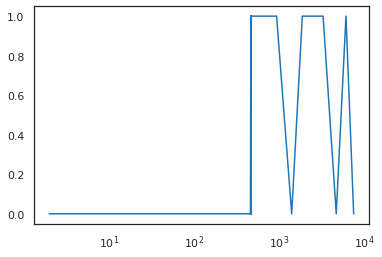

In [107]:
plt.plot(df['n_total_leaves'][:-1], (np.diff(mean_sim_entropy)) > 0)
plt.xscale('log')
plt.show()

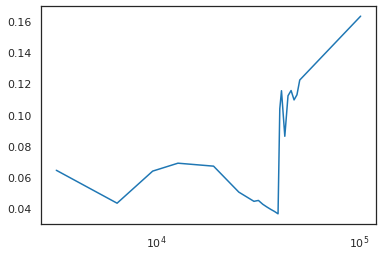

In [23]:
plt.plot(df['n_parameters'], [np.mean(irm) for irm in irms])
plt.xscale('log')
plt.show()

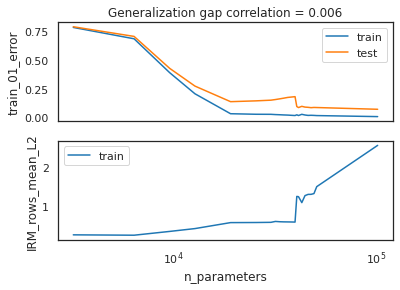

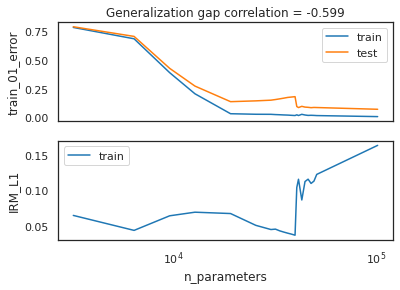

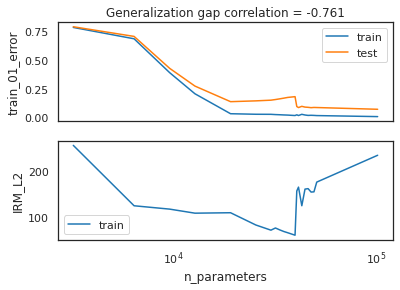

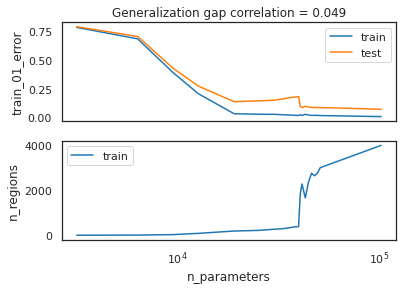

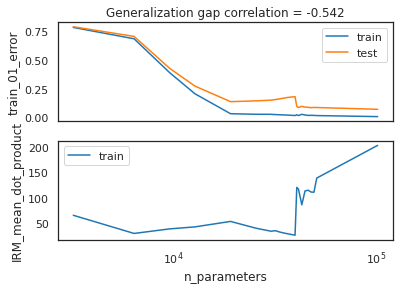

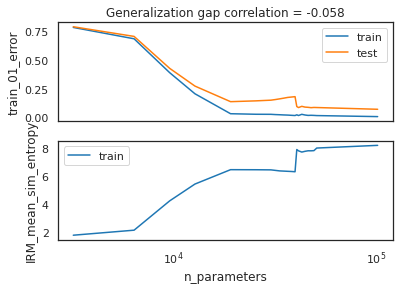

In [24]:
## Correlation variables
corr_vars = [
    'IRM_rows_mean_L2',
    'IRM_L1', 'IRM_L2', 'n_regions',
    'IRM_mean_dot_product', 'IRM_mean_sim_entropy',
]


for var in corr_vars:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
            
    sns.lineplot(
        data=plot_df, x=x_var, y=train_error,
        ax=ax1, label='train')
    sns.lineplot(
        data=plot_df, x=x_var, y=test_error,
        ax=ax1, label='test')
    sns.lineplot(
        data=plot_df, x=x_var, y=var,
        ax=ax2, label='train')

    plt.xscale('log')
    
    corr, _ = spearmanr(df['generalization_gap'], df[var])
    ax1.set_title(f'Generalization gap correlation = {corr:.3f}')
    plt.legend()
    plt.show()

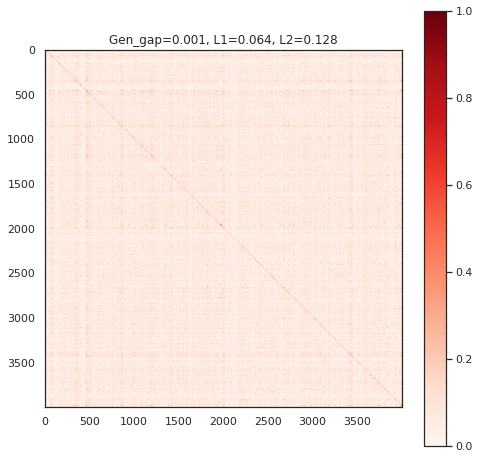

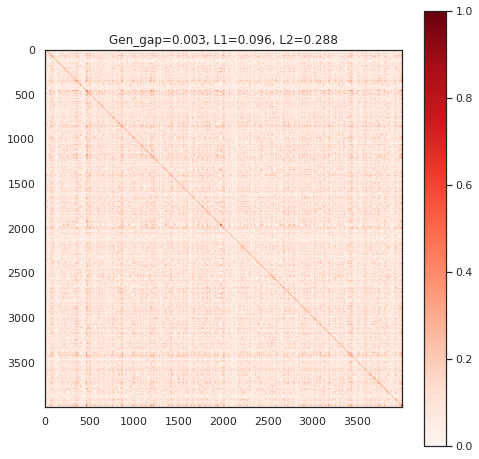

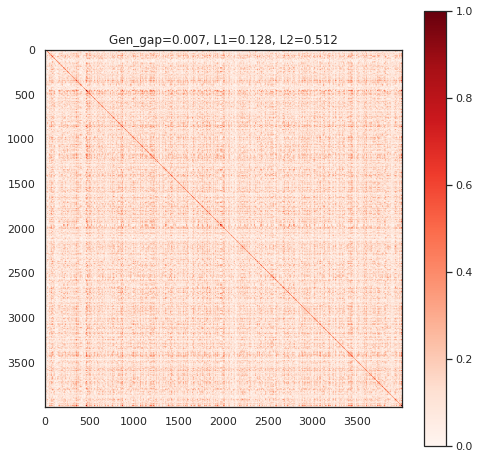

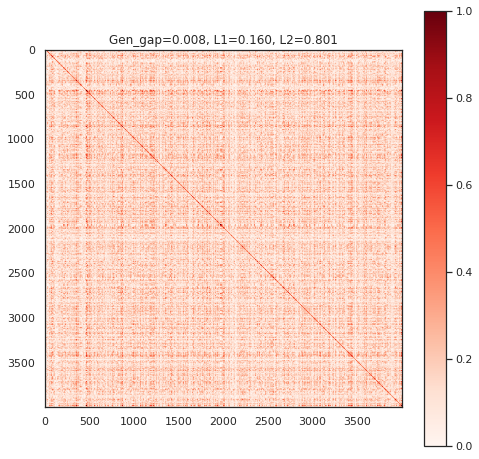

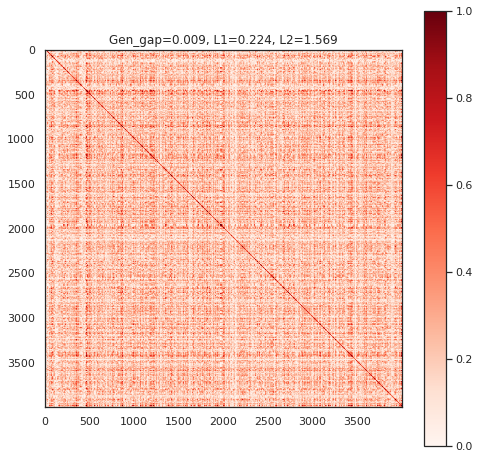

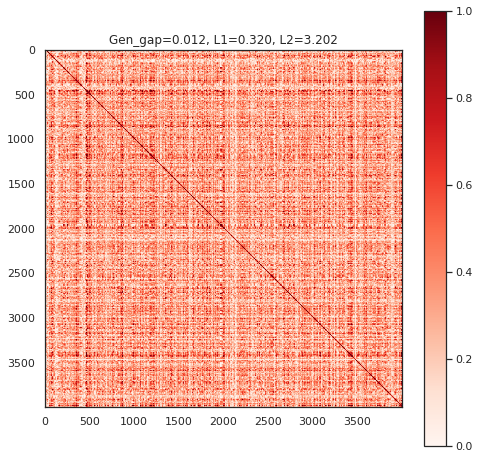

KeyboardInterrupt: 

In [28]:
MM_L1 = []
MM_L2 = []
for gen_gap, irm in zip(df['generalization_gap'], irms):
    M = irm @ irm.T # / irm.sum(1)[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(M, cmap='Reds', vmin=0, vmax=1)  
    
    MM_L1.append(np.mean(M))
    MM_L2.append(np.mean(M**2))
    plt.title(f'Gen_gap={gen_gap:.3f}, L1={MM_L1[-1]:.3f}, L2={MM_L2[-1]:.3f}')
    plt.colorbar()
    plt.show()

In [ ]:
plt.plot(np.arange(len(MM_L1)), MM_L1, label='L1')
plt.plot(np.arange(len(MM_L2)), MM_L2, label='L2')
plt.legend()
plt.show()

## Playground

In [66]:
X_train, y_train = load_mnist(
    random_state = 1,
    train=True,
    n_samples=4000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True,
)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test, y_test = load_mnist(
    random_state = 1234,
    train=False,
    n_samples=10000,
    save_path="/mnt/ssd3/ronan/pytorch",
    onehot=True
)
X_test = scaler.transform(X_test)

/mnt/ssd3/ronan/miniconda3/envs/proglearn/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [68]:
widths = [512] # [8, 12, 16, 24, 32, 64, 128, 256]
gen_errors = []
irms = []
train_errors = []
test_errors = []
for width in widths:
    print(width, end=', ')
    model = ReluNetRegressor(
        hidden_layer_dims=[width], n_epochs=100,
        **{
            "learning_rate": 1e-2,
            "batch_size": 32,
            "verbose": 1,
            "early_stop_thresh": 0,
            "bias": True,
        }
    )
    # model = ReluNetClassifier(hidden_layer_dims=[width], n_epochs=500)
    model = model.fit(X_train, y_train)
    train_errors.append(np.mean(np.linalg.norm(y_train - model.predict(X_train), axis=1)))
    test_errors.append(np.mean(np.linalg.norm(y_test - model.predict(X_test), axis=1)))
    gen_errors.append(test_errors[-1] - train_errors[-1])
    irms.append(model.get_internal_representation(X_train))

512, Results for epoch 1, MSELoss=0.04, mse=0.04
Results for epoch 6, MSELoss=0.02, mse=0.02
Results for epoch 11, MSELoss=0.02, mse=0.02
Results for epoch 16, MSELoss=0.01, mse=0.01
Results for epoch 21, MSELoss=0.02, mse=0.02
Results for epoch 26, MSELoss=0.01, mse=0.01
Results for epoch 31, MSELoss=0.02, mse=0.02
Results for epoch 36, MSELoss=0.01, mse=0.01
Results for epoch 41, MSELoss=0.01, mse=0.01
Results for epoch 46, MSELoss=0.01, mse=0.01
Results for epoch 51, MSELoss=0.01, mse=0.01
Results for epoch 56, MSELoss=0.01, mse=0.01
Results for epoch 61, MSELoss=0.02, mse=0.02
Results for epoch 66, MSELoss=0.02, mse=0.02
Results for epoch 71, MSELoss=0.02, mse=0.02
Results for epoch 76, MSELoss=0.01, mse=0.01
Results for epoch 81, MSELoss=0.02, mse=0.02
Results for epoch 86, MSELoss=0.01, mse=0.01
Results for epoch 91, MSELoss=0.02, mse=0.02
Results for epoch 96, MSELoss=0.01, mse=0.01


In [73]:
entropy(np.linalg.svd(irms[0], compute_uv=False)**2)

3.59735951387819

In [81]:
def max_eval_entropy(n, m, r):
    n = int(n)
    m = int(m)
    if r < 1:
        r = r * n * m
    X = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            X[(i+j) % n, j] = 1
            r -= 1
            if r < 1:
                break
        if r < 1:
            break
    return X # entropy(np.linalg.svd(X, compute_uv=False)**2)

In [78]:
np.unique(irms[0])

array([0, 1])

In [82]:
X = max_eval_entropy(4000, 512, np.mean(irms[0]))

In [89]:
(np.linalg.svd(X, compute_uv=False)**2)[0]

540692.8128675275

In [90]:
irm_evals = np.linalg.svd(irms[0], compute_uv=False)**2
X_evals = np.linalg.svd(X, compute_uv=False)**2

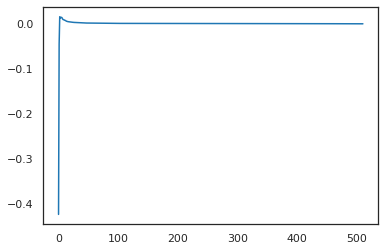

In [92]:
plt.plot(np.arange(512), irm_evals / irm_evals.sum() - X_evals / X_evals.sum(), label='IRM')
# plt.plot(np.arange(512), , label='X')
plt.show()

In [76]:
np.mean(irms[0])

0.3062919921875

In [92]:
idxs = np.argsort(y_train.argmax(1))
irms = [irm[idxs] for irm in irms]

In [121]:
def mean_sim_entropy(X):
    score = 0
    for row in X:
        sims = X @ row
        score += entropy(sims) if sims.sum() > 0 else 0
    score /= X.shape[0]
    return score

Ms = [irm @ irm.T / irm.shape[1] for irm in irms]
l1_scores = np.asarray([np.mean(M) for M in Ms])
l2_scores = np.asarray([np.mean(M**2) for M in Ms])
irm_mean = np.asarray([np.mean(irm) for irm in irms])
mean_entropy_v2_scores = np.asarray([mean_sim_entropy(irm) for irm in irms])

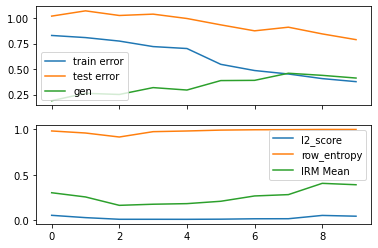

In [122]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(np.arange(len(gen_errors)), train_errors, label='train error')
axes[0].plot(np.arange(len(gen_errors)), test_errors, label='test error')
axes[0].plot(np.arange(len(gen_errors)), gen_errors, label='gen')

axes[0].legend()

# axes[1].plot(np.arange(len(gen_errors)), l1_scores, label='l1_score')
axes[1].plot(np.arange(len(gen_errors)), l2_scores, label='l2_score')
axes[1].plot(np.arange(len(gen_errors)), mean_entropy_v2_scores / max(mean_entropy_v2_scores), label='row_entropy')
axes[1].plot(np.arange(len(gen_errors)), irm_mean, label='IRM Mean')
axes[1].legend()
plt.show()

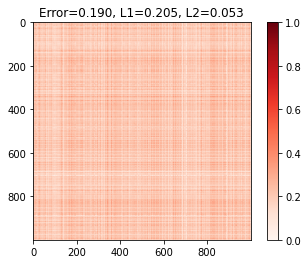

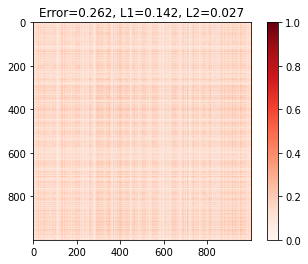

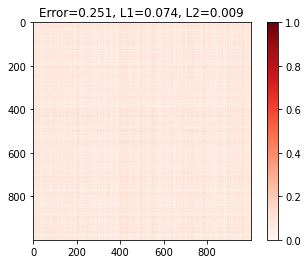

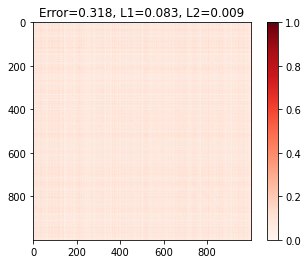

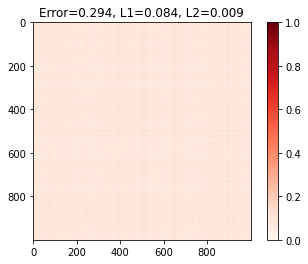

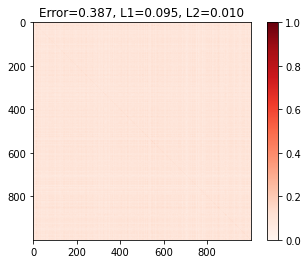

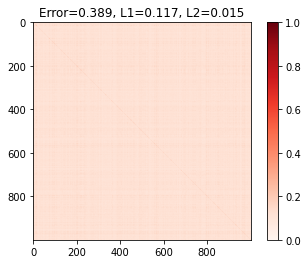

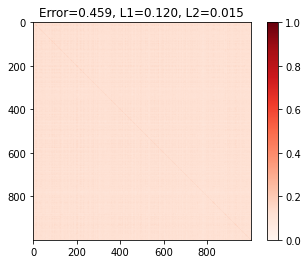

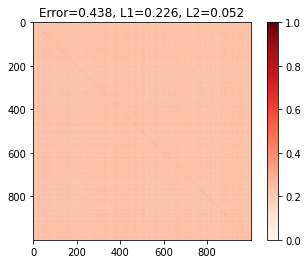

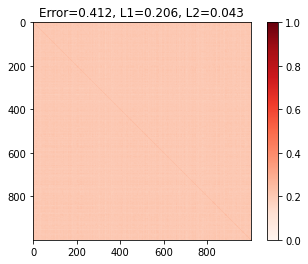

In [123]:
for irm, gen_error in zip(irms, gen_errors):
    M = irm @ irm.T / irm.shape[1]
    plt.imshow(M, vmin=0, vmax=1, cmap='Reds')
    plt.title(f'Error={gen_error:.3f}, L1={np.mean(M):.3f}, L2={np.mean(M**2):.3f}')
    plt.colorbar()
    plt.show()

## Forest metric

In [110]:
X_train, y_train = generate_gaussian_parity(
    n_samples=200, angle_params=0, random_state=1, cov_scale=1.0
)
X_test, y_test = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=1234, cov_scale=1.0
)

In [111]:
irms = []
max_depths = [8, None, None]
n_estimators = [1, 1, 10]
for n_trees, md in zip(n_estimators, max_depths):
    model = RandomForestClassifier(n_estimators=n_trees, bootstrap=False, max_depth=md)
    model.fit(X_train, y_train)
    irms.append(get_forest_irm(model, X_train))

3.1380452798942797
2.1602720866537566
0.06355


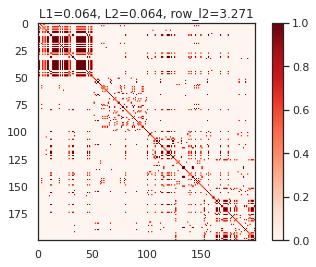

3.761421033502677
1.5368963330453598
0.0405


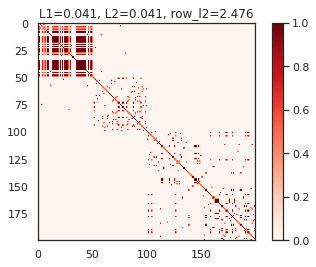

4.206849031018148
2.243881796704879
0.0791


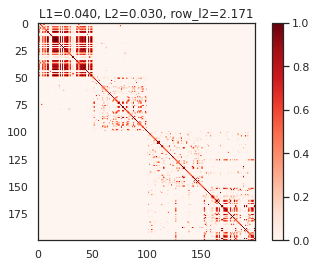

In [112]:
for irm in irms:
    M = irm @ irm.T / irm.sum(1)[0]
    mean_row_l2 = np.mean(np.linalg.norm(M, axis=1))
    print(entropy(np.linalg.svd(irm, compute_uv=False)**2))
    print(np.mean(entropy(M, axis=1)))
    print(np.mean(M > 0))
    plt.imshow(M, vmin=0, vmax=1, cmap='Reds')
    plt.title(f'L1={np.mean(M):.3f}, L2={np.mean(M**2):.3f}, row_l2={mean_row_l2:.3f}')
    plt.colorbar()
    plt.show()

In [51]:
X0 = np.asarray([[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
X1 = np.asarray([[2, 2, 2, 0], [2, 2, 2, 0], [2,2,2,0],[0,0,0,2]]) / 2
X2 = np.asarray([[2,2,1,0],[2,2,1,0],[1,1,2,1],[0,0,1,2]]) / 2

print(np.mean(np.linalg.norm(X0, axis=1)))
print(np.mean(np.linalg.norm(X1, axis=1)))
print(np.mean(np.linalg.norm(X2, axis=1)))

print(np.mean(entropy(X0, axis=1)))
print(np.mean(entropy(X1, axis=1)))
print(np.mean(entropy(X2, axis=1)))

2.0
1.549038105676658
1.3602274110705475
1.3862943611198906
0.8239592165010822
1.0196333861193059
